# 1.) Import an asset price from Yahoo Finance

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 1.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [42]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
# I chose Starbucks from 2018-01-01 to 2022-02-21
stock_data = yf.download("SBUX", start="2018-01-01", end="2022-02-21")


# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :].copy()

[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [43]:
x_train = []
y_train = []
#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5

In [44]:
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])
y_train=np.where(np.array(y_train)>0,1,0) 

In [45]:
from os import access
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1,activation="sigmoid"))
#Examples
#model.add(LSTM(50, return_sequences=False))
#model.add(Dense(25))


model.compile(optimizer='adam', loss='mean_squared_error')
fit = model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
827/827 [==============================] - 10s 6ms/step - loss: 0.2498
Epoch 2/3
827/827 [==============================] - 6s 8ms/step - loss: 0.2492
Epoch 3/3
827/827 [==============================] - 5s 7ms/step - loss: 0.2492


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [46]:
pred = np.where(model.predict(x_train)<0.5,0,1)
pred = pred.flatten()
in_rmse = np.sqrt(np.mean(pred-y_train)**2)
in_rw=np.sqrt(np.mean(y_train)**2)
print("In sample accuracy: ",in_rmse)
print("In sample random walk accuracy: ",in_rw)

26/26 [==============================] - 1s 3ms/step
In sample accuracy:  0.4607013301088271
In sample random walk accuracy:  0.5392986698911729


In [47]:
test_data = scaled_data[training_data_len - input_size:, :].copy()
x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
y_test = np.where(np.array(y_test)>0,1,0) 

In [48]:
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


predictions = model.predict(x_test)

7/7 [==============================] - 0s 4ms/step


In [49]:
preds = np.where(predictions<0.5,0,1)
preds = preds.flatten()
out_rmse = np.sqrt(np.mean(preds-y_test)**2)
out_rw=np.sqrt(np.mean(y_test)**2)
print("Out of sample accuracy: ",out_rmse)
print("Out of sample random walk accuracy: ",out_rw)

Out of sample accuracy:  0.5119617224880383
Out of sample random walk accuracy:  0.4880382775119617


<BarContainer object of 2 artists>

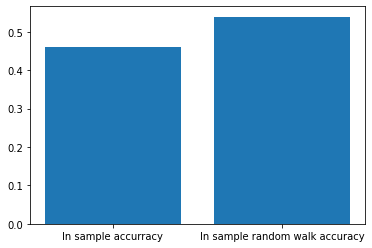

In [50]:
import matplotlib.pyplot as plt
plt.bar(["In sample accurracy","In sample random walk accuracy"],[in_rmse,in_rw])

<BarContainer object of 2 artists>

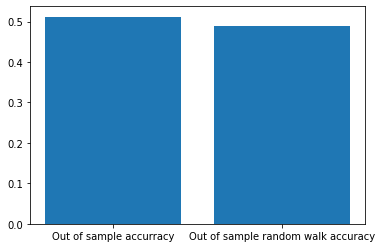

In [51]:
plt.bar(["Out of sample accurracy","Out of sample random walk accuracy"],[out_rmse,out_rw])

# 4.) (Skip) Plot in and out of sample accuracy 

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

The graphs from Q4 could be quite misleading because even though the accuracy is quite horrible, the graphs from Q4 still look good.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

From the results below, the best parameter is {'batch_size': 10, 'epochs': 1, 'input_size': 20} and the best score is -0.6908502380053202.

In [52]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
###Edit here to create your optimizer
def create_model(input_size): 
  stock_data = yf.download("SBUX", start="2018-01-01", end="2022-02-21")
  scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)
  training_data_len = int(len(scaled_data) * 0.8)
  train_data = scaled_data[0:training_data_len, :].copy()
  x_train=[]
  y_train=[]
  for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])
  y_train = np.where(np.array(y_train)>0,1,0) 
  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  model = Sequential()
  model.add(LSTM(input_size, return_sequences=True, input_shape=(input_size, 1)))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return(model)

# Case1: input_size=5 
input_size=5

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)


# Define the hyperparameters to search over
param_grid = {'batch_size': [10, 20, 100],
              'epochs': [1],
              "input_size":[input_size]}

# Perform the grid search over the hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)
print("Best parameter:",grid.best_params_)
print("Best score:",grid.best_score_)

<ipython-input-52-0ab9a35c4831>:31: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


[*********************100%***********************]  1 of 1 completed
Best parameter: {'batch_size': 20, 'epochs': 1, 'input_size': 5}
Best score: -0.6912487943967184


In [55]:
# Case1: input_size=10 
input_size=10

def create_model(input_size): 
  model = Sequential()
  model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return(model)

stock_data = yf.download("SBUX", start="2018-01-01", end="2022-02-21")
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :].copy()
x_train=[]
y_train=[]
for i in range(input_size, len(train_data)):
  x_train.append(train_data[i-input_size:i, 0])
  y_train.append(train_data[i, 0])
y_train = np.where(np.array(y_train)>0,1,0) 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)


# Define the hyperparameters to search over
param_grid = {'batch_size': [10, 20, 100],
              'epochs': [1],
              "input_size":[input_size]}

# Perform the grid search over the hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)
print("Best parameter:",grid.best_params_)
print("Best score:",grid.best_score_)

[*********************100%***********************]  1 of 1 completed


<ipython-input-55-2f23d2fe0e0b>:26: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best parameter: {'batch_size': 10, 'epochs': 1, 'input_size': 10}
Best score: -0.6909667650858561


In [56]:
# Case1: input_size=20 
input_size=20

def create_model(input_size): 
  model = Sequential()
  model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return(model)

stock_data = yf.download("SBUX", start="2018-01-01", end="2022-02-21")
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :].copy()
x_train=[]
y_train=[]
for i in range(input_size, len(train_data)):
  x_train.append(train_data[i-input_size:i, 0])
  y_train.append(train_data[i, 0])
y_train = np.where(np.array(y_train)>0,1,0) 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)


# Define the hyperparameters to search over
param_grid = {'batch_size': [10, 20, 100],
              'epochs': [1],
              "input_size":[input_size]}

# Perform the grid search over the hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)
print("Best parameter:",grid.best_params_)
print("Best score:",grid.best_score_)

[*********************100%***********************]  1 of 1 completed


<ipython-input-56-b261e112f917>:26: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best parameter: {'batch_size': 10, 'epochs': 1, 'input_size': 20}
Best score: -0.6908502380053202
